In [385]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import itertools
from functools import reduce

In [386]:
N = 2
dev = qml.device('default.qubit', wires=N)

In [387]:
from sklearn.datasets import make_moons
from sklearn.utils.random import sample_without_replacement

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA



In [388]:
def gen_new_data():
    bc = make_moons(n_samples = 20, random_state=0, noise=0.1)

    bc_data = bc[0]
    bc_target = np.array([1 if y == 0 else -1 for y in bc[1]])

    scaler = preprocessing.MinMaxScaler(feature_range=(0, np.pi))
    bc_norm = scaler.fit(bc_data).transform(bc_data)

    bc_proc = bc_norm
    
    global num_data
    num_data = len(bc_target)
    
    return bc_proc, bc_target

Now we add implicit features corresponding to the two-point all-pairs parity

$$
\phi_{i, j}(x) = (\pi - x_i)(\pi - x_j)
$$

In [389]:
#print("train data: ", train_data)
#print("test data: ", test_data)

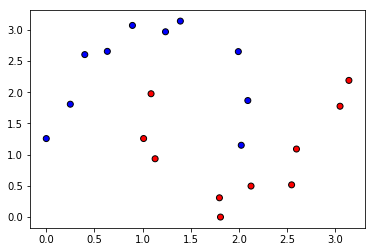

In [390]:
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

plt.figure()
plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc_target,cmap=cm_bright, edgecolors='k')
plt.show()

In [391]:
#import sys
#import numpy
#numpy.set_printoptions(threshold=sys.maxsize)

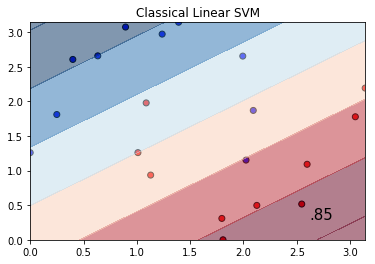

In [392]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(bc_proc.data, bc_target)

score = clf.score(bc_proc.data, bc_target)

x_min = y_min = 0
x_max = y_max = np.pi
h = .02  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid) 
Z = Z.reshape(xx.shape)

#for i in range(int(x_max / h)):
#    if Z[0, i] > 0:
#        print(Z[0, i], grid[i])

plt.figure()

plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc_target, cmap=cm_bright, edgecolors='k')
plt.contourf(xx, yy, Z, vmin=-1., vmax=1., cmap=cm, alpha=.5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.title("Classical Linear SVM")
plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

plt.show()

In [393]:
def U_phi(x):
    # x_2 = (pi - x_0)(pi - x_1)
    
    for i in range(N):
        qml.RZ( x[i], wires=0)
    
    
    for (j, pair) in enumerate(itertools.combinations(range(N), r=2)):
        qml.CNOT(wires=[pair[0], pair[1]])
        qml.RZ(x[N + j], pair[1])
        qml.CNOT(wires=[pair[0], pair[1]])

In [394]:
def featuremap(x):
    for i in range(2):
        for j in range(N):
            qml.Hadamard(wires=j)
        U_phi(x)

In [395]:
def layer(W): # 6 weights are specified at each layer
    
    for i in range(N): 
        if i == (N-1):
            qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
            qml.Rot(W[N-1, 0], W[N-1, 1], W[N-1, 2], wires=N-1)
            
            qml.CNOT(wires=[0, N-1])
        else: 
            # euler angles
            qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
            qml.Rot(W[i+1, 0], W[i+1, 1], W[i+1, 2], wires=i + 1)

            qml.CNOT(wires=[i, i+1])

In [396]:
@qml.qnode(dev)
def circuit(weights, x, n=0):

    featuremap(x)

    for W in weights:
        layer(W)

    return qml.expval.PauliZ(wires=n)

In [397]:
def variational_classifier(var, x): # x is a keyword argument -> fixed (not trained)
    weights = var[0]
    bias = var[1]
    
    exp_Z = circuit(weights, x, n=0)
    for i in range(1, N):
        #print("computing expectation at index {0}".format(i))
        e = circuit(weights,x,n=i)
        exp_Z *= e

    return exp_Z + bias

In [398]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)

    return loss

In [399]:
def accuracy(labels, predictions):
    #print(labels, predictions)
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [400]:
def cost(var, X, Y):

    predictions = [variational_classifier(var, x) for x in X]
    #if (len(Y) == num_data):
    #    print("[(pred, label), ...]: ", list(zip(predictions, Y)))
    
    sq_l = square_loss(Y, predictions) 
    
    #print("square loss: ", sq_l)
    return sq_l

In [401]:
num_iterations = 30

def train_and_test(X, Y):
    opt = NesterovMomentumOptimizer(0.02)
    batch_size = 5
    var_init = (0.01 * np.random.randn(layers, N, 3), 0.0)
    
    # train the variational classifier
    var = var_init
    
    min_cost = 100.
    min_cost_var = []
    train_accuracies = []
    costs = []
    for it in range(num_iterations):

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_data, (batch_size, ))
        X_train_batch = X[batch_index]
        Y_train_batch = Y[batch_index]
        var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)
        #print("Var: ", var)

        # Compute predictions on train and validation set
        
        predictions_train = [np.sign(variational_classifier(var, f)) for f in X]

        # Compute accuracy on train and validation set
        acc_train = accuracy(Y, predictions_train)
        
        # Compute cost on all samples
        c = cost(var, X, Y)
        
        if c < min_cost:
            min_cost = c
            min_cost_var = var
        
        costs.append(c)
        train_accuracies.append(acc_train)
        
        print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f}"
              "".format(it+1, c, acc_train))
        
    return train_accuracies, costs, min_cost_var

In [ ]:
from scipy.special import comb

#thresholds = [0.0, 0.1, 0.2, 0.3]
gammas = [0.0, 0.5, 1.0, 1.5, 2.0]

gam_train_acc_map = {}
gam_cost_map = {}
gam_vars_map = {}
    
bc_proc, bc_target = gen_new_data()

for g in gammas:
        print("gamma: ", g)
        new_features = np.zeros((num_data, int(comb(N, 2))))

        for i in range(num_data):
            for (j, pair) in enumerate(itertools.combinations(range(N), r=2)):
                new_features[i, j] = g * (np.pi - bc_proc[i, pair[0]]) * (np.pi - bc_proc[i, pair[1]])

        all_data = np.append(bc_proc, new_features, 1)
        print(np.shape(bc_proc), np.shape(new_features), np.shape(all_data))
        
        gam_train_accuracies = []
        gam_costs = []
        gam_vars = []
        
        for shot in range(20):
            trn_ac, costs, var = train_and_test(
                all_data, bc_target)
        
            gam_train_accuracies.append(trn_ac)
            gam_costs.append(costs)
            gam_vars.append(var)
        
            print("Var: ", var)
        
        gam_train_acc_map[g] = gam_train_accuracies
        gam_cost_map[g] = gam_costs
        gam_vars_map[g] = gam_vars
        
# TODO - print var when max acc achieved

gamma:  0.0
(20, 2) (20, 1) (20, 3)
Iter:     1 | Cost: 1.5119471 | Acc train: 0.4500000
Iter:     2 | Cost: 1.5583793 | Acc train: 0.4500000
Iter:     3 | Cost: 1.5309066 | Acc train: 0.5000000
Iter:     4 | Cost: 1.4701335 | Acc train: 0.4500000
Iter:     5 | Cost: 1.3864562 | Acc train: 0.4500000
Iter:     6 | Cost: 1.3045471 | Acc train: 0.5000000
Iter:     7 | Cost: 1.2507842 | Acc train: 0.5500000
Iter:     8 | Cost: 1.2205861 | Acc train: 0.5000000
Iter:     9 | Cost: 1.2096428 | Acc train: 0.5000000
Iter:    10 | Cost: 1.2116869 | Acc train: 0.5000000
Iter:    11 | Cost: 1.1843836 | Acc train: 0.5000000
Iter:    12 | Cost: 1.1495250 | Acc train: 0.5000000
Iter:    13 | Cost: 1.1312970 | Acc train: 0.5500000
Iter:    14 | Cost: 1.1267946 | Acc train: 0.5500000
Iter:    15 | Cost: 1.1230377 | Acc train: 0.5000000
Iter:    16 | Cost: 1.1182815 | Acc train: 0.5000000
Iter:    17 | Cost: 1.1220368 | Acc train: 0.5000000
Iter:    18 | Cost: 1.1399012 | Acc train: 0.5000000
Iter:    1

Iter:     1 | Cost: 1.4202558 | Acc train: 0.5000000
Iter:     2 | Cost: 1.2852901 | Acc train: 0.5000000
Iter:     3 | Cost: 1.1991645 | Acc train: 0.4500000
Iter:     4 | Cost: 1.1695707 | Acc train: 0.4500000
Iter:     5 | Cost: 1.1362288 | Acc train: 0.5000000
Iter:     6 | Cost: 1.1415650 | Acc train: 0.5000000
Iter:     7 | Cost: 1.1855651 | Acc train: 0.5000000
Iter:     8 | Cost: 1.2678674 | Acc train: 0.5000000
Iter:     9 | Cost: 1.2298873 | Acc train: 0.5000000
Iter:    10 | Cost: 1.1697015 | Acc train: 0.5000000
Iter:    11 | Cost: 1.0839917 | Acc train: 0.5000000
Iter:    12 | Cost: 1.0211329 | Acc train: 0.5000000
Iter:    13 | Cost: 0.9901165 | Acc train: 0.5500000
Iter:    14 | Cost: 0.9857155 | Acc train: 0.5500000
Iter:    15 | Cost: 0.9785479 | Acc train: 0.6000000
Iter:    16 | Cost: 0.9971977 | Acc train: 0.5000000
Iter:    17 | Cost: 1.0105777 | Acc train: 0.5000000
Iter:    18 | Cost: 1.0176493 | Acc train: 0.5000000
Iter:    19 | Cost: 0.9774510 | Acc train: 0.5

Iter:     4 | Cost: 1.2087220 | Acc train: 0.5000000
Iter:     5 | Cost: 1.1431370 | Acc train: 0.5500000
Iter:     6 | Cost: 1.1030423 | Acc train: 0.5500000
Iter:     7 | Cost: 1.0563884 | Acc train: 0.5000000
Iter:     8 | Cost: 0.9855504 | Acc train: 0.5500000
Iter:     9 | Cost: 0.9395271 | Acc train: 0.5500000
Iter:    10 | Cost: 0.9139775 | Acc train: 0.6000000
Iter:    11 | Cost: 0.9289118 | Acc train: 0.6000000
Iter:    12 | Cost: 0.9206974 | Acc train: 0.6000000
Iter:    13 | Cost: 0.9162914 | Acc train: 0.6000000
Iter:    14 | Cost: 0.9009066 | Acc train: 0.7000000
Iter:    15 | Cost: 0.9101988 | Acc train: 0.6500000
Iter:    16 | Cost: 0.9171884 | Acc train: 0.5000000
Iter:    17 | Cost: 0.8869807 | Acc train: 0.7000000
Iter:    18 | Cost: 0.8498597 | Acc train: 0.7000000
Iter:    19 | Cost: 0.8673554 | Acc train: 0.6500000
Iter:    20 | Cost: 0.8854912 | Acc train: 0.6500000
Iter:    21 | Cost: 0.9293885 | Acc train: 0.6000000
Iter:    22 | Cost: 0.9725145 | Acc train: 0.5

Iter:     7 | Cost: 1.0964575 | Acc train: 0.5000000
Iter:     8 | Cost: 1.1071171 | Acc train: 0.5000000
Iter:     9 | Cost: 1.1123560 | Acc train: 0.5000000
Iter:    10 | Cost: 1.0940370 | Acc train: 0.5000000
Iter:    11 | Cost: 1.0346768 | Acc train: 0.5000000
Iter:    12 | Cost: 0.9548119 | Acc train: 0.5500000
Iter:    13 | Cost: 0.9522584 | Acc train: 0.6000000
Iter:    14 | Cost: 1.0116145 | Acc train: 0.5000000
Iter:    15 | Cost: 1.1225732 | Acc train: 0.5000000
Iter:    16 | Cost: 1.1440942 | Acc train: 0.5000000
Iter:    17 | Cost: 1.1136619 | Acc train: 0.5000000
Iter:    18 | Cost: 1.0205678 | Acc train: 0.5000000
Iter:    19 | Cost: 0.9347572 | Acc train: 0.5000000
Iter:    20 | Cost: 0.9020876 | Acc train: 0.7000000
Iter:    21 | Cost: 0.8896383 | Acc train: 0.7000000
Iter:    22 | Cost: 0.8830599 | Acc train: 0.7000000
Iter:    23 | Cost: 0.8644037 | Acc train: 0.8000000
Iter:    24 | Cost: 0.8601886 | Acc train: 0.6500000
Iter:    25 | Cost: 0.8650559 | Acc train: 0.7

Iter:     8 | Cost: 0.9553529 | Acc train: 0.5000000
Iter:     9 | Cost: 0.9468614 | Acc train: 0.6500000
Iter:    10 | Cost: 0.9553138 | Acc train: 0.7500000
Iter:    11 | Cost: 0.9836058 | Acc train: 0.5000000
Iter:    12 | Cost: 0.9892262 | Acc train: 0.6000000
Iter:    13 | Cost: 1.0019010 | Acc train: 0.5500000
Iter:    14 | Cost: 0.9990315 | Acc train: 0.4500000
Iter:    15 | Cost: 1.0059954 | Acc train: 0.6000000
Iter:    16 | Cost: 1.0215530 | Acc train: 0.5000000
Iter:    17 | Cost: 0.9695465 | Acc train: 0.5500000
Iter:    18 | Cost: 0.9295011 | Acc train: 0.6000000
Iter:    19 | Cost: 0.8932274 | Acc train: 0.6500000
Iter:    20 | Cost: 0.8665623 | Acc train: 0.7000000
Iter:    21 | Cost: 0.8864908 | Acc train: 0.6500000
Iter:    22 | Cost: 0.9800993 | Acc train: 0.5500000
Iter:    23 | Cost: 1.0326968 | Acc train: 0.5000000
Iter:    24 | Cost: 1.0557434 | Acc train: 0.4500000
Iter:    25 | Cost: 1.0585621 | Acc train: 0.3500000
Iter:    26 | Cost: 1.0420792 | Acc train: 0.4

Iter:    10 | Cost: 1.2805784 | Acc train: 0.3500000
Iter:    11 | Cost: 1.2693468 | Acc train: 0.3500000
Iter:    12 | Cost: 1.2454714 | Acc train: 0.3500000
Iter:    13 | Cost: 1.2148006 | Acc train: 0.3500000
Iter:    14 | Cost: 1.1632947 | Acc train: 0.3000000
Iter:    15 | Cost: 1.1045419 | Acc train: 0.3000000
Iter:    16 | Cost: 1.0547210 | Acc train: 0.2500000
Iter:    17 | Cost: 1.0150909 | Acc train: 0.4000000
Iter:    18 | Cost: 0.9905598 | Acc train: 0.5500000
Iter:    19 | Cost: 0.9874772 | Acc train: 0.5000000
Iter:    20 | Cost: 1.0142490 | Acc train: 0.5000000
Iter:    21 | Cost: 1.0585303 | Acc train: 0.5000000
Iter:    22 | Cost: 1.0650046 | Acc train: 0.5000000
Iter:    23 | Cost: 1.0860181 | Acc train: 0.5000000
Iter:    24 | Cost: 1.1037761 | Acc train: 0.5000000
Iter:    25 | Cost: 1.1211564 | Acc train: 0.5000000
Iter:    26 | Cost: 1.1333594 | Acc train: 0.5000000
Iter:    27 | Cost: 1.1202599 | Acc train: 0.5000000
Iter:    28 | Cost: 1.0902903 | Acc train: 0.5

Iter:    13 | Cost: 0.9756821 | Acc train: 0.5000000
Iter:    14 | Cost: 1.0244464 | Acc train: 0.5000000
Iter:    15 | Cost: 1.0427954 | Acc train: 0.5000000
Iter:    16 | Cost: 1.0541756 | Acc train: 0.5000000
Iter:    17 | Cost: 1.0541679 | Acc train: 0.5000000
Iter:    18 | Cost: 1.0384726 | Acc train: 0.5000000
Iter:    19 | Cost: 1.0192726 | Acc train: 0.5000000
Iter:    20 | Cost: 0.9864277 | Acc train: 0.5000000
Iter:    21 | Cost: 0.9385534 | Acc train: 0.5000000
Iter:    22 | Cost: 0.9006726 | Acc train: 0.7000000
Iter:    23 | Cost: 0.8762395 | Acc train: 0.7000000
Iter:    24 | Cost: 0.8628598 | Acc train: 0.7000000
Iter:    25 | Cost: 0.8574514 | Acc train: 0.7000000
Iter:    26 | Cost: 0.8509286 | Acc train: 0.7000000
Iter:    27 | Cost: 0.8602469 | Acc train: 0.7500000
Iter:    28 | Cost: 0.8777565 | Acc train: 0.7000000
Iter:    29 | Cost: 0.8801425 | Acc train: 0.7000000
Iter:    30 | Cost: 0.8668273 | Acc train: 0.7500000
Var:  [array([[[-0.16956071, -0.52272891, -0.1

Iter:    16 | Cost: 1.0665522 | Acc train: 0.5000000
Iter:    17 | Cost: 1.0261477 | Acc train: 0.5000000
Iter:    18 | Cost: 1.0007352 | Acc train: 0.5500000
Iter:    19 | Cost: 0.9778480 | Acc train: 0.6500000
Iter:    20 | Cost: 0.9640708 | Acc train: 0.6000000
Iter:    21 | Cost: 0.9562079 | Acc train: 0.5000000
Iter:    22 | Cost: 0.9528303 | Acc train: 0.5000000
Iter:    23 | Cost: 0.9545295 | Acc train: 0.5000000
Iter:    24 | Cost: 0.9621584 | Acc train: 0.5000000
Iter:    25 | Cost: 0.9610593 | Acc train: 0.5000000
Iter:    26 | Cost: 0.9536414 | Acc train: 0.5000000
Iter:    27 | Cost: 0.9416432 | Acc train: 0.5000000
Iter:    28 | Cost: 0.9409739 | Acc train: 0.5000000
Iter:    29 | Cost: 0.9518184 | Acc train: 0.5000000
Iter:    30 | Cost: 0.9649479 | Acc train: 0.5000000
Var:  [array([[[-0.00852635, -0.41491148, -0.01962768],
        [ 0.11697904,  0.00671372,  0.14429204]],

       [[ 0.00236481, -0.38019071, -0.01749007],
        [ 0.09192343,  0.02430337,  0.10113813]],

Iter:    19 | Cost: 1.0087761 | Acc train: 0.5000000
Iter:    20 | Cost: 0.9552996 | Acc train: 0.5000000
Iter:    21 | Cost: 0.9127316 | Acc train: 0.5500000
Iter:    22 | Cost: 0.8778409 | Acc train: 0.6500000
Iter:    23 | Cost: 0.8541943 | Acc train: 0.7000000
Iter:    24 | Cost: 0.8452403 | Acc train: 0.7500000
Iter:    25 | Cost: 0.8759326 | Acc train: 0.6000000
Iter:    26 | Cost: 0.9097472 | Acc train: 0.6000000
Iter:    27 | Cost: 0.9346669 | Acc train: 0.6000000
Iter:    28 | Cost: 0.9202710 | Acc train: 0.6000000
Iter:    29 | Cost: 0.8959773 | Acc train: 0.6500000
Iter:    30 | Cost: 0.9059547 | Acc train: 0.6000000
Var:  [array([[[ 0.3208026 , -0.62119314,  0.28029441],
        [-0.07313688,  0.04750198,  0.02037949]],

       [[ 0.21319882, -0.67187119,  0.10491596],
        [-0.13245616,  0.09616808, -0.03944209]],

       [[ 0.04801475, -0.64787929, -0.00360818],
        [-0.16768053,  0.19975275, -0.02873352]],

       [[-0.03632416, -0.62338708, -0.03776186],
        

Iter:    22 | Cost: 0.8773006 | Acc train: 0.6000000
Iter:    23 | Cost: 0.8642228 | Acc train: 0.7000000
Iter:    24 | Cost: 0.8655673 | Acc train: 0.7000000
Iter:    25 | Cost: 0.8697025 | Acc train: 0.7000000
Iter:    26 | Cost: 0.8760022 | Acc train: 0.7000000
Iter:    27 | Cost: 0.8879971 | Acc train: 0.7000000
Iter:    28 | Cost: 0.8882190 | Acc train: 0.7000000
Iter:    29 | Cost: 0.8884799 | Acc train: 0.7500000
Iter:    30 | Cost: 0.8805736 | Acc train: 0.7000000
Var:  [array([[[ 0.24803463, -0.61119706,  0.2119301 ],
        [-0.04606438,  0.11896861,  0.01650755]],

       [[ 0.13723534, -0.64555869,  0.08447915],
        [-0.06741078,  0.09857399,  0.00326753]],

       [[ 0.0413736 , -0.68968435, -0.02386963],
        [-0.08391983,  0.11784291,  0.01115162]],

       [[-0.05767647, -0.68831298, -0.04797893],
        [-0.06471998,  0.12972149, -0.01267349]]]), -0.09894670222269669]
Iter:     1 | Cost: 1.3229766 | Acc train: 0.4500000
Iter:     2 | Cost: 1.3205783 | Acc trai

Iter:    24 | Cost: 0.9377430 | Acc train: 0.5000000
Iter:    25 | Cost: 0.9539459 | Acc train: 0.5500000
Iter:    26 | Cost: 0.9690814 | Acc train: 0.6000000
Iter:    27 | Cost: 0.9712345 | Acc train: 0.5500000
Iter:    28 | Cost: 0.9518055 | Acc train: 0.6500000
Iter:    29 | Cost: 0.9333992 | Acc train: 0.5500000
Iter:    30 | Cost: 0.9346678 | Acc train: 0.5500000
Var:  [array([[[ 0.02760694, -0.29768382,  0.05112156],
        [ 0.07603187,  0.33070004,  0.04990467]],

       [[ 0.09926652, -0.31462354,  0.12706095],
        [-0.03847857,  0.1999259 , -0.05661545]],

       [[ 0.11181993, -0.37326135,  0.08467929],
        [-0.06968312, -0.03152731, -0.0980771 ]],

       [[ 0.05367425, -0.38557634,  0.01263686],
        [-0.052991  , -0.21757988, -0.04838888]]]), 0.09037697069625211]
Iter:     1 | Cost: 1.1394782 | Acc train: 0.4500000
Iter:     2 | Cost: 1.1036539 | Acc train: 0.5000000
Iter:     3 | Cost: 1.0518522 | Acc train: 0.5500000
Iter:     4 | Cost: 1.0249433 | Acc train

Iter:    27 | Cost: 0.9846768 | Acc train: 0.6500000
Iter:    28 | Cost: 0.9882938 | Acc train: 0.4500000
Iter:    29 | Cost: 0.9913595 | Acc train: 0.4500000
Iter:    30 | Cost: 0.9929577 | Acc train: 0.4500000
Var:  [array([[[-0.20660016,  0.3730607 , -0.16672148],
        [-0.26031135, -0.4163971 , -0.25189406]],

       [[-0.12336531,  0.46521784, -0.08682663],
        [-0.25030512, -0.30081116, -0.25007439]],

       [[-0.0547213 ,  0.51684568, -0.02117629],
        [-0.19771549, -0.19160163, -0.1784932 ]],

       [[-0.01179904,  0.52801862,  0.02012897],
        [-0.08386772, -0.09575505, -0.06638746]]]), -0.005005440347816401]
Iter:     1 | Cost: 1.1650636 | Acc train: 0.4000000
Iter:     2 | Cost: 1.1482363 | Acc train: 0.4500000
Iter:     3 | Cost: 1.1197412 | Acc train: 0.4500000
Iter:     4 | Cost: 1.0851288 | Acc train: 0.5000000
Iter:     5 | Cost: 1.0436413 | Acc train: 0.6500000
Iter:     6 | Cost: 1.0169746 | Acc train: 0.7000000
Iter:     7 | Cost: 0.9886817 | Acc tra

Iter:    28 | Cost: 0.8778685 | Acc train: 0.6000000
Iter:    29 | Cost: 0.8964348 | Acc train: 0.6500000
Iter:    30 | Cost: 0.9018946 | Acc train: 0.6500000
Var:  [array([[[ 0.08661349, -0.47316026,  0.06355472],
        [-0.01166421,  0.24640028,  0.00527912]],

       [[ 0.07680382, -0.42510049,  0.09468161],
        [-0.10430055,  0.13907368, -0.08819593]],

       [[ 0.13542234, -0.38622155,  0.10325329],
        [-0.13921286, -0.04434688, -0.18373253]],

       [[ 0.09327486, -0.32441649,  0.04293832],
        [-0.11922663, -0.27037083, -0.12001039]]]), -0.00825804930586478]
Iter:     1 | Cost: 1.1583799 | Acc train: 0.4500000
Iter:     2 | Cost: 1.1115042 | Acc train: 0.5500000
Iter:     3 | Cost: 1.1011549 | Acc train: 0.5000000
Iter:     4 | Cost: 1.0944367 | Acc train: 0.5000000
Iter:     5 | Cost: 1.0973378 | Acc train: 0.5000000
Iter:     6 | Cost: 1.0864085 | Acc train: 0.5500000
Iter:     7 | Cost: 1.0888204 | Acc train: 0.6000000
Iter:     8 | Cost: 1.0679867 | Acc trai

Iter:     1 | Cost: 1.1287884 | Acc train: 0.4500000
Iter:     2 | Cost: 1.0988556 | Acc train: 0.6000000
Iter:     3 | Cost: 1.0559016 | Acc train: 0.6000000
Iter:     4 | Cost: 1.0177539 | Acc train: 0.6500000
Iter:     5 | Cost: 0.9912386 | Acc train: 0.7000000
Iter:     6 | Cost: 0.9629071 | Acc train: 0.6000000
Iter:     7 | Cost: 0.9404793 | Acc train: 0.5500000
Iter:     8 | Cost: 0.9245160 | Acc train: 0.6000000
Iter:     9 | Cost: 0.9106655 | Acc train: 0.6000000
Iter:    10 | Cost: 0.9025107 | Acc train: 0.6000000
Iter:    11 | Cost: 0.8993062 | Acc train: 0.6500000
Iter:    12 | Cost: 0.8998678 | Acc train: 0.6500000
Iter:    13 | Cost: 0.8958978 | Acc train: 0.6500000
Iter:    14 | Cost: 0.8814129 | Acc train: 0.6500000
Iter:    15 | Cost: 0.8825176 | Acc train: 0.5500000
Iter:    16 | Cost: 0.8952856 | Acc train: 0.5000000
Iter:    17 | Cost: 0.8942014 | Acc train: 0.5500000
Iter:    18 | Cost: 0.8923779 | Acc train: 0.6000000
Iter:    19 | Cost: 0.8889317 | Acc train: 0.5

In [ ]:
from scipy.special import comb

#thresholds = [0.0, 0.1, 0.2, 0.3]
num_layers = [4]
layers_train_accuracies = []
layers_costs = []
layers_vars = []
    
for layers in num_layers:
        print("layers: ", layers)
        new_features = np.zeros((num_data, int(comb(N, 2))))

        for i in range(num_data):
            for (j, pair) in enumerate(itertools.combinations(range(N), r=2)):
                new_features[i, j] = (np.pi - bc_proc[i, pair[0]]) * (np.pi - bc_proc[i, pair[1]])

        all_data = np.append(bc_proc, new_features, 1)
        print(np.shape(bc_proc), np.shape(new_features), np.shape(all_data))
        
        trn_ac, costs, var = train_and_test(
            all_data, bc_target)
        layers_train_accuracies.append(trn_ac)
        layers_costs.append(costs)
        layers_vars.append(var)
        print("Var: ", var)

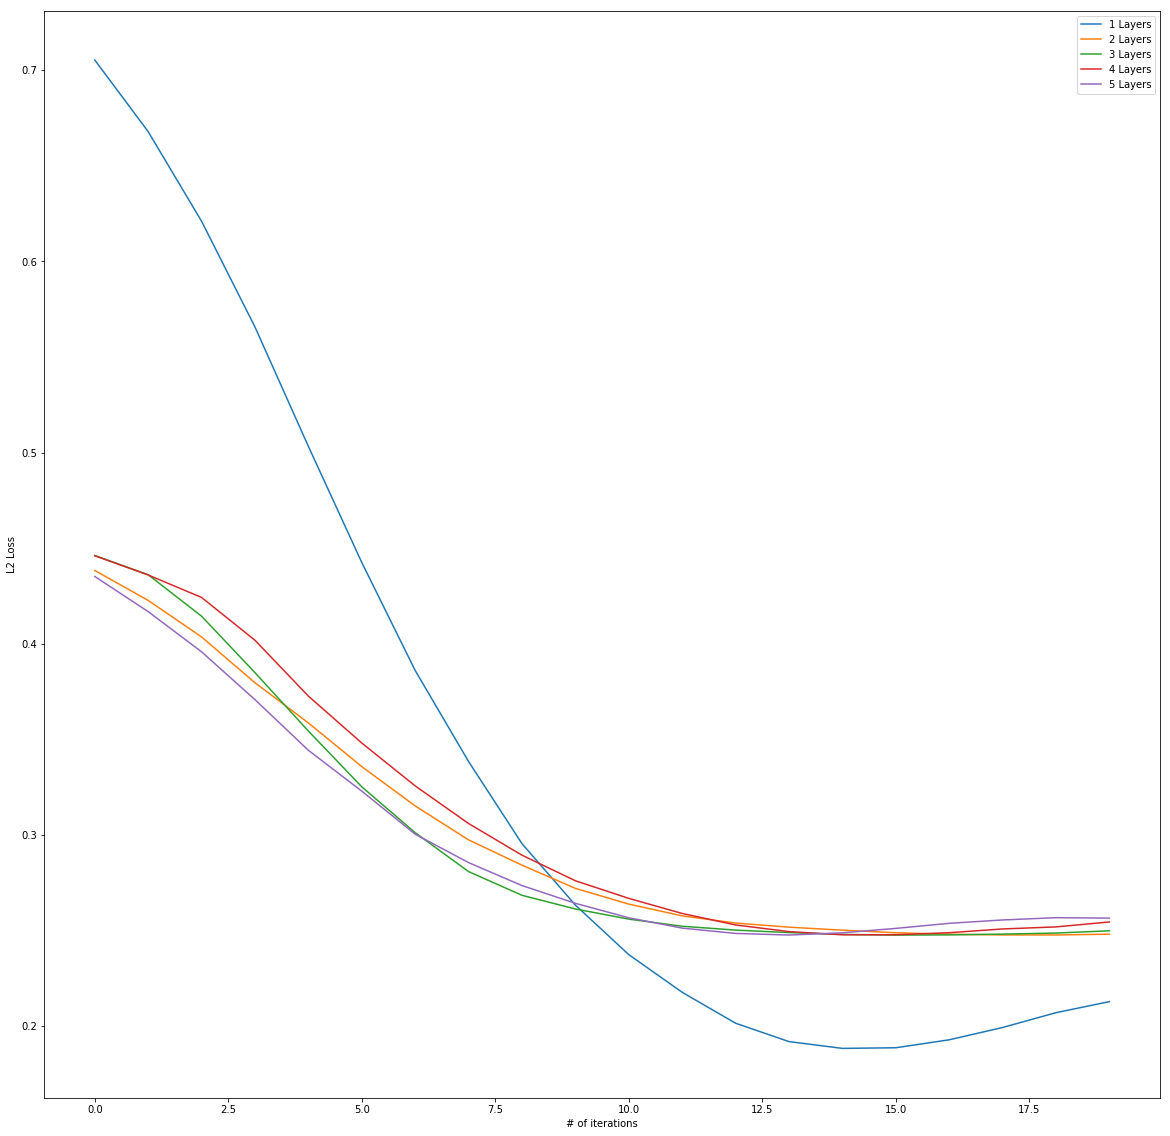

In [19]:
%matplotlib inline

plt.figure(figsize=(20,20)) 

for i, l in enumerate(num_layers):
    plt.plot(layers_costs[i], '-', label='%i Layers' % l)

plt.xlabel('# of iterations')
plt.ylabel('L2 Loss')
plt.legend(loc='best')

#plt.tight_layout()
plt.show()

In [104]:
var1 = [np.array([[[-0.01453474, -0.12898417, -0.02433007],
        [-0.00569958, -0.09413766,  0.00802958]],

       [[-0.01810061, -0.11672242, -0.01718347],
        [-0.01067066, -0.08566914, -0.00844553]],

       [[-0.03140817, -0.11196483, -0.03242999],
        [-0.01095938, -0.0726931 , -0.00563176]],

       [[-0.00986964, -0.11341817, -0.0151284 ],
        [-0.00815413, -0.06492449, -0.00469989]]]), 0.6906673783231684]

In [191]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, gamma):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress ({2}): [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100, gamma)
    print(text)

In [366]:
#score = gam_train_accuracies[0][-1]
print(layers_vars)

x_min = y_min = 0
x_max = y_max = np.pi
h = 0.1  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

Z_dict = {}

for idx, l in enumerate(num_layers):
    Z = np.array([])

    for i, f in enumerate(grid):
        feat = np.append(f, (np.pi - f[0])*(np.pi - f[1]))
        Z = np.append(Z, np.sign(variational_classifier(layers_vars[idx], feat)))
        update_progress(i / len(grid), l)

    update_progress(1, l)
    Z = Z.reshape(xx.shape)
    Z_dict[l] = Z 
 
update_progress(1, 0.0)

Progress (4): [#-------------------] 5.6%


KeyboardInterrupt: 

In [372]:
#score = gam_train_accuracies[0][-1]
print(gam_vars)

x_min = y_min = 0
x_max = y_max = np.pi
h = 0.1  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

Z_dict = {}

for idx, g in enumerate(gammas):
    Z = np.array([])

    for i, f in enumerate(grid):
        feat = np.append(f, g * (np.pi - f[0])*(np.pi - f[1]))
        Z = np.append(Z, np.sign(variational_classifier(gam_vars[idx], feat)))
        update_progress(i / len(grid), g)

    update_progress(1, g)
    Z = Z.reshape(xx.shape)
    Z_dict[g] = Z 
 
update_progress(1, 0.0)

Progress (0.0): [####################] 100.0%


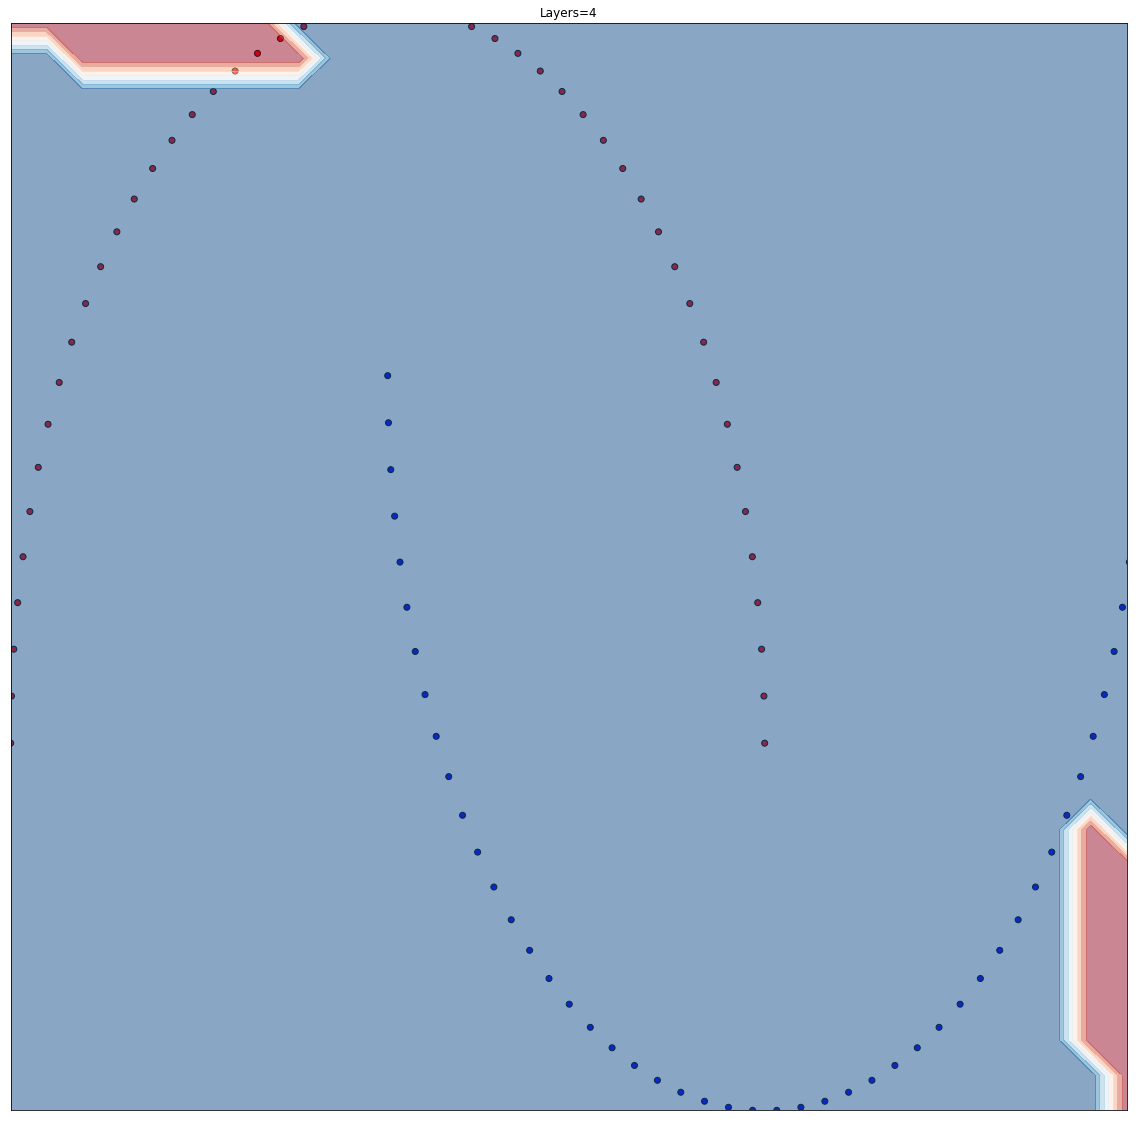

In [65]:
plt.figure(figsize=(20,20))

scores = layers_costs

for i, l in enumerate(num_layers):
    score = scores[i]
    
    plt.subplot(len(num_layers), 1, i + 1)
    plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc_target,cmap=cm_bright, edgecolors='k')
    plt.contourf(xx, yy, Z_dict[l], vmin=-1., vmax=1., cmap=cm, alpha=.5)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.title("Layers=%i" % l)

   # plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % scores[i]).lstrip('0'),
   #                 size=15, horizontalalignment='right')

plt.show()

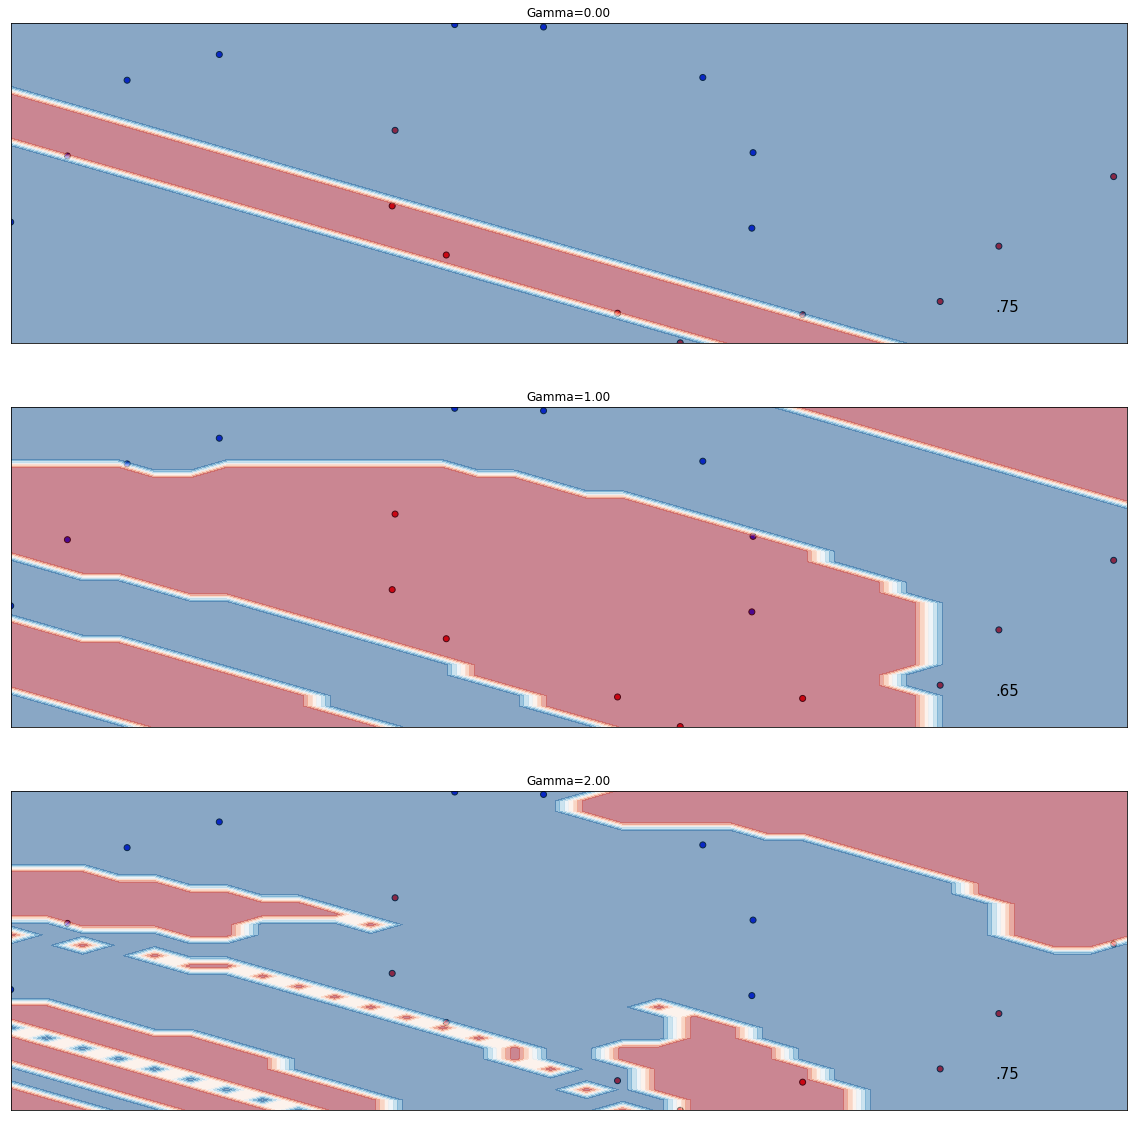

In [376]:
plt.figure(figsize=(20,20))

scores = [0.75, 0.65, 0.75]
for i, g in enumerate(gammas):
    
    plt.subplot(len(gammas), 1, i + 1)
    plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc_target,cmap=cm_bright, edgecolors='k')
    plt.contourf(xx, yy, Z_dict[g], vmin=-1., vmax=1., cmap=cm, alpha=.5)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.title("Gamma=%0.2f" % g)

    plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % scores[i]).lstrip('0'),
                    size=15, horizontalalignment='right')

plt.show()

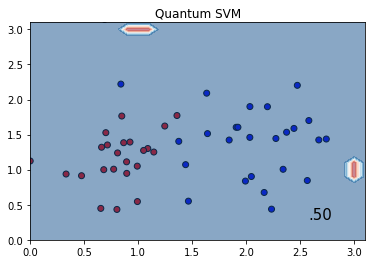

In [28]:
plt.figure()

plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc.target, cmap=cm_bright, edgecolors='k')
plt.contourf(xx, yy, Z, vmin=-1., vmax=1., cmap=cm, alpha=.5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.title("Quantum SVM")

plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

plt.show()

In [380]:
def hada(ket):
    H = [[1, 1], [1, -1]] / np.sqrt(2)
    return np.matmul(H, ket)

def rot_Z(phi, ket):
    mat = [[np.exp(-1.j * phi) , 0], [0, np.exp(1.j * phi)]]
    return np.matmul(mat, ket)

def U_phi(x, ket1, ket2, gamma):
    ket1 = rot_Z(p[0], ket1)
    ket2 = rot_Z(p[1], ket2)
    
    phase = gamma * (np.pi - p[0]) * (np.pi - p[1])
    ket1 = rot_Z(phase, ket1)
    ket2 = rot_Z(phase, ket2)
    
    return ket1, ket2

def all_had(ket1, ket2):
    return hada(ket1), hada(ket2)

def feature_map(x, gamma):
    ket1 = [1, 0]
    ket2 = [1, 0]
    
    ket1, ket2 = U_phi(x, ket1, ket2, gamma)
    ket1, ket2 = all_had(ket1, ket2)
    ket1, ket2 = U_phi(x, ket1, ket2, gamma)
    ket1, ket2 = all_had(ket1, ket2)
    
    #print(np.linalg.norm(ket1), np.linalg.norm(ket2))
    kr = np.kron(ket1, ket2)
    #print("norm kron", np.linalg.norm(kr)) # checks out
    #print("trace of outer", np.trace(np.outer(np.conj(kr),kr))) # should be same as above
    return np.outer(np.conj(kr),kr)

ls = np.linspace(0, 2.0, 50, endpoint=True)
t = []
for g in ls:
    print("gamma: \n", g)
    pos = bc_proc[bc_target == 1]
    neg = bc_proc[bc_target != 1]

    pos_dm = np.zeros((4, 4), dtype='complex128')
    neg_dm = np.zeros((4, 4), dtype='complex128')

    for p in pos:
        u_x = feature_map(p, g)
        pos_dm +=  u_x / len(pos)

    for n in neg:
        u_x = feature_map(n, g)
        neg_dm += u_x / len(neg)

    print("trace of +1 density matrix: ", np.trace(pos_dm))
    print("trace of -1 density matrix: ", np.trace(neg_dm))
    
    print(pos_dm)
    diff = pos_dm - neg_dm
    w, v = np.linalg.eig(diff)

    #print(w)
    td = 0.5 * np.linalg.norm(w, 1)
    print("trace distance: ", td)
    t.append(td)
    
    
    

gamma: 
 0.0
trace of +1 density matrix:  (0.9999999999999993+0j)
trace of -1 density matrix:  (0.9999999999999991+0j)
[[ 1.99149288e-01+0.00000000e+00j -9.97465999e-19+6.76841268e-02j
  -4.29344060e-18-1.21845614e-01j  3.65221034e-02+8.32667268e-18j]
 [-9.97465999e-19-6.76841268e-02j  2.58414357e-01+0.00000000e+00j
  -3.65221034e-02+3.12250226e-18j  6.72205347e-18+3.70937966e-02j]
 [-4.29344060e-18+1.21845614e-01j -3.65221034e-02-3.12250226e-18j
   3.67720004e-01+0.00000000e+00j -3.20923843e-18+6.71858537e-02j]
 [ 3.65221034e-02-8.32667268e-18j  6.72205347e-18-3.70937966e-02j
  -3.20923843e-18-6.71858537e-02j  1.74716352e-01+0.00000000e+00j]]
trace distance:  0.8103377107606857
gamma: 
 0.04081632653061224
trace of +1 density matrix:  (0.9999999999999992+0j)
trace of -1 density matrix:  (0.9999999999999991+0j)
[[ 1.98206885e-01+0.00000000e+00j -2.38524478e-19+9.19040694e-02j
   8.58688121e-18-1.31176980e-01j  3.70542627e-02-1.27068495e-17j]
 [-2.38524478e-19-9.19040694e-02j  2.4751582

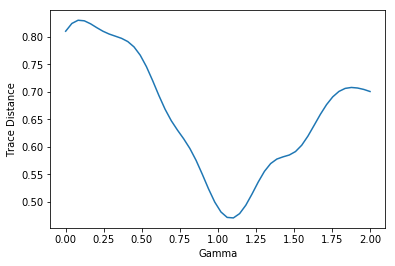

In [381]:
plt.figure()

plt.ylabel("Trace Distance")
plt.xlabel("Gamma")
plt.plot(ls, t)

plt.show()